In [1]:
DIR = 'F:/'
TRAIN_DF_PATH = DIR + "train.csv"
TEST_DF_PATH = DIR + 'test.csv'
TRAIN_IMG_PATH = DIR + "train_images/"
TEST_IMG_PATH = DIR + 'test_images/'
BASE_DIR = 'F:/'
TRAIN_IMAGE_DIR = 'F:/train_images'
TEST_IMAGE_DIR = 'F:/test_images'
train_csv = 'F:/train.csv'
test_csv = 'F:/test.csv'
IMAGE_SIZE = 224
BATCH_SIZE = 10

In [2]:
import numpy as np
import pandas as pd
import json
import math
import os

In [3]:
train_df = pd.read_csv(TRAIN_DF_PATH)
train_df.head(10)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
5,0083ee8054ee,4
6,0097f532ac9f,0
7,00a8624548a9,2
8,00b74780d31d,2
9,00cb6555d108,1


In [4]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'

In [5]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
encoded_diagnosis = onehot_encoder.fit_transform(train_df[['diagnosis']])
print(encoded_diagnosis)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [6]:
print(encoded_diagnosis.shape)
print(encoded_diagnosis.astype)

(3662, 5)
<built-in method astype of numpy.ndarray object at 0x00000210B2512EE0>


In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

Using TensorFlow backend.


In [8]:
train_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'training',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'validation',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout,GlobalAveragePooling2D
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import layers
from keras import regularizers, optimizers
from keras.callbacks import Callback, ModelCheckpoint

In [10]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2 
iresnet = InceptionResNetV2(include_top = False, weights='imagenet', input_shape=(224,224,3))
model = Sequential()
model.add(iresnet)
# model.add(Conv2D(filters = 1024, kernel_size = (2,2),padding = 'same'))
# model.add(BatchNormalization())
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
Total params: 54,344,421
Trainable params: 54,283,877
Non-trainable params: 60,544
_________________________________________________________________


In [12]:
checkpoint = ModelCheckpoint(
    'inceptres.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [14]:
history =model.fit_generator(generator=train_gen,              
                                    steps_per_epoch=len(train_gen)//BATCH_SIZE,
                                    validation_data=test_gen,                    
                                    validation_steps=len(test_gen)//BATCH_SIZE,
                                    epochs=30,
                                    
                                    verbose=1)
model.save('inceptionresnet.h5')

Epoch 1/30
29/29 [==============================] - 724s 25s/step - loss: 0.4798 - accuracy: 0.7910 - val_loss: 0.4310 - val_accuracy: 0.8286
Epoch 2/30
29/29 [==============================] - 662s 23s/step - loss: 0.3103 - accuracy: 0.8772 - val_loss: 0.3818 - val_accuracy: 0.8886
Epoch 3/30
29/29 [==============================] - 701s 24s/step - loss: 0.2609 - accuracy: 0.8972 - val_loss: 0.3676 - val_accuracy: 0.8743
Epoch 4/30
29/29 [==============================] - 798s 28s/step - loss: 0.2459 - accuracy: 0.8979 - val_loss: 0.2426 - val_accuracy: 0.8829
Epoch 5/30
29/29 [==============================] - 666s 23s/step - loss: 0.2492 - accuracy: 0.8993 - val_loss: 0.2396 - val_accuracy: 0.8971
Epoch 6/30
29/29 [==============================] - 625s 22s/step - loss: 0.2733 - accuracy: 0.8828 - val_loss: 0.2414 - val_accuracy: 0.8714
Epoch 7/30
29/29 [==============================] - 630s 22s/step - loss: 0.2578 - accuracy: 0.8966 - val_loss: 0.1089 - val_accuracy: 0.9229
Epoch 

In [15]:
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

74/74 [==============================] - 374s 5s/step


In [16]:
loss, accuracy = model.evaluate_generator(test_gen, steps=3, verbose=1)
print("Loss of the model: ",loss)
print("Accuracy of the model: ",accuracy)

3/3 [==============================] - 17s 6s/step
Loss of the model:  0.21110384166240692
Accuracy of the model:  0.9266666173934937


In [17]:
from matplotlib import pyplot as plt

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


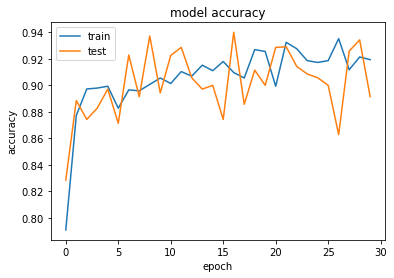

In [18]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


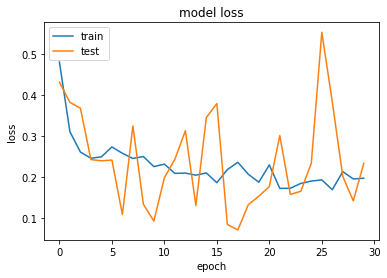

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()